## 导入数据及预处理

In [1]:
! pip install pandas numpy matplotlib seaborn scikit-learn

In [2]:
import pandas as pd
import numpy as np

In [3]:
def preprocess_abundance(abu, level):
    abu = abu.T # 转置
    abu = abu.loc[:,abu.sum(axis=0) > 0] # 去除全为0的特征
    abu.columns = abu.columns.str.split(';', expand=True) # 将分类信息拆分为多列
    abu.columns = abu.columns.get_level_values(level) # 选择指定层级的分类信息
    abu = abu.loc[:,abu.columns.notnull()] # 去除分类信息为空的特征
    abu = abu.groupby(abu.columns, axis=1).sum() # 按分类信息聚合\
    return abu
    

导入数据

In [4]:
X_train = pd.read_csv('data/SourceCM.csv', index_col=0)
X_test = pd.read_csv('data/QueryCM.csv', index_col=0)
y_test = pd.read_csv('data/QueryLabel.csv', index_col=0)
y_train = pd.read_csv('data/SourceLabel.csv', index_col=0)

In [5]:
X_train.describe()

,ERR1583385,SRR1179327,ERR2725605,SRR1930725,ERR1582517,SRR5002888,ERR2816769,SRR3633495,SRR1179400,SRR5185957,...,ERR2842512,SRR6464907,SRR6507601,SRR5287300,SRR5188799,SRR5433944,SRR6979560,ERZ1026917,SRR5189471,DRR161763
count,22264.000000,22264.000000,22264.000000,22264.000000,22264.000000,22264.000000,22264.000000,22264.000000,22264.000000,22264.000000,...,22264.000000,22264.000000,22264.000000,22264.000000,22264.000000,22264.000000,22264.000000,22264.000000,22264.000000,22264.000000
mean,0.827839,0.069484,12.233067,0.068092,3.525871,1.850925,0.508489,10.392248,0.088124,0.821416,...,2.433570,11.569664,0.915649,2.242364,1.022952,2.172655,1.407384,0.001527,0.261948,4.296622
std,37.482177,4.810983,1074.944411,7.912178,109.927733,126.267472,30.164713,457.971651,5.847863,55.633609,...,176.537092,487.568618,53.407367,142.308668,134.154945,148.418884,31.414896,0.065649,13.749833,197.344444
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,4943.000000,661.000000,156303.000000,1175.000000,10484.000000,17821.000000,3547.000000,42734.000000,815.000000,6712.000000,...,22301.000000,47513.000000,5582.000000,16619.000000,19995.000000,18688.000000,2528.000000,7.000000,1567.000000,21015.000000


丰度表预处理

In [6]:
X_train = preprocess_abundance(X_train, 5)  # 保留到属
X_test = preprocess_abundance(X_test, 5)  # 保留到属

C:\Users\26638\AppData\Local\Temp\ipykernel_69380\805183115.py:7: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  abu = abu.groupby(abu.columns, axis=1).sum() # 按分类信息聚合\
C:\Users\26638\AppData\Local\Temp\ipykernel_69380\805183115.py:7: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  abu = abu.groupby(abu.columns, axis=1).sum() # 按分类信息聚合\


In [7]:
X_test = pd.concat([pd.DataFrame(columns=X_train.columns), X_test], join='outer', axis=0).fillna(0)  # 特征对齐
X_test = X_test[X_train.columns]

X_train = X_train.div(X_train.sum(axis=1), axis=0)  # 相对丰度
X_test = X_test.div(X_test.sum(axis=1), axis=0) # 相对丰度

C:\Users\26638\AppData\Local\Temp\ipykernel_69380\3161395271.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_test = pd.concat([pd.DataFrame(columns=X_train.columns), X_test], join='outer', axis=0).fillna(0)  # 特征对齐


In [8]:
X_train.head()

,g__,g__Abiotrophia,g__Acanthamoeba,g__Acanthometra,g__Acanthopleuribacter,g__Acarothrix,g__Acartia,g__Acaryochloris,g__Acetanaerobacterium,g__Acetatifactor,...,g__Zhihengliuella,g__Zhongshania,g__Zobellella,g__Zobellia,g__Zoogloea,g__Zooshikella,g__Zoothamnium,g__Zosterodasys,g__Zunongwangia,g__Zymomonas
ERR1583385,0.000995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
SRR1179327,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
ERR2725605,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
SRR1930725,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
ERR1582517,0.002837,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000039,0.0,0.0,0.0,0.0,0.0


利用训练集的丰度表进行标准化

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

标签预处理

In [10]:
y_train = y_train['Env'].str.split(':', expand=True)    # 样本来源分层
y_train = y_train.drop(columns=[0]) # 去除root
y_test = y_test['Env'].str.split(':', expand=True)    # 样本来源分层
y_test = y_test.drop(columns=[0]) # 去除root

In [11]:
y_train.head()

,1,2,3,4,5
ERR1583385,Environmental,Aquatic,Freshwater,Wetlands,Bog
SRR1179327,Host-associated,Mammals,Digestive system,Stomach,Rumen
ERR2725605,Host-associated,Mammals,Digestive system,Stomach,Rumen
SRR1930725,Environmental,Aquatic,Freshwater,Groundwater,Biofilm
ERR1582517,Environmental,Aquatic,Freshwater,Wetlands,Bog


## 模型构建

In [12]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

In [13]:
def construct_model(X_train, y_train):
    le = LabelEncoder()
    le.fit_transform(y_train)   # 将分类标签编码为数字
    clf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
    clf.fit(X_train, y_train)
    return clf, le

对最后一层建模

In [14]:
model, le = construct_model(X_train, y_train.iloc[:, -1])

在测试集上评估

In [15]:
y_score = model.predict_proba(X_test)
y_true = le.transform(y_test.iloc[:, -1])

In [16]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

def roc_auc_calculate(y_query, y_proba):
    classes = np.unique(y_query)
    Nclasses = len(classes)
    y_test = np.eye(Nclasses)[y_query]

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(Nclasses):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_proba[:, i])
        roc_auc[i] = float(format(auc(fpr[i], tpr[i]), '.5f'))
    
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(Nclasses)]))#数组拼接得到fpr的矩阵

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)  #构造数字都为0的矩阵，为做平均做准备
    for i in range(Nclasses):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= Nclasses

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = float(format(auc(fpr["macro"], tpr["macro"]), '.5f'))
    

    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_proba.ravel())
    roc_auc["micro"] = float(format(auc(fpr["micro"], tpr["micro"]), '.5f'))
    
    roc_auc["ovr"] = float(format(roc_auc_score(y_query, y_proba, multi_class='ovr'), '.5f'))
    roc_auc["ovo"] = float(format(roc_auc_score(y_query, y_proba, multi_class='ovo'), '.5f'))
    return roc_auc, fpr, tpr

In [17]:
roc_auc, fpr, tpr = roc_auc_calculate(y_true, y_score)

## 可视化

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

d:\conda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\conda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


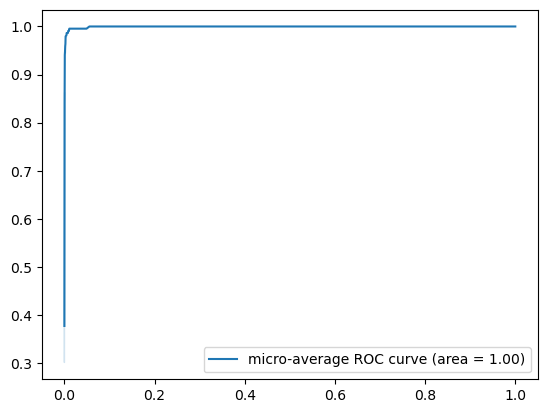

In [19]:
fig = sns.lineplot(x=fpr['micro'], 
                   y=tpr['micro'], 
                   label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc['macro']))